In [ ]:
# default_exp data.external

In [ ]:
# hide
import sys

sys.path.append("..")

# Data Collection

> Adding the M4 data to the fastai way of storing/downloading data.

Datasets to incl:

- [x] m4 daily
- [ ] gunpoint
- [ ] Phoneme <http://www.timeseriesclassification.com/description.php?Dataset=Phoneme>
- [ ] Worms <http://www.timeseriesclassification.com/description.php?Dataset=Worms>
- [ ] BeetleFly <http://www.timeseriesclassification.com/description.php?Dataset=BeetleFly>
- [ ] m4 hourly

using zip files
https://forums.fast.ai/t/generalizing-untar-data-to-also-work-with-zips/53741/14?u=takotab

In [ ]:
# export
from fastseq.core import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
# hide
URLs.IMAGEWOOF

'https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2.tgz'

In [ ]:
# hide
path = untar_data(URLs.IMAGEWOOF)

In [ ]:
# hide
path.ls()

(#2) [Path('/home/tako/.fastai/data/imagewoof2/val'),Path('/home/tako/.fastai/data/imagewoof2/train')]

In [ ]:
# export
m4_base = "https://motionnet-m4-dataset.s3.eu-central-1.amazonaws.com/"
URLs.m4_daily = f'{m4_base}m4_daily.tgz'

In [ ]:
URLs.m4_daily

'https://motionnet-m4-dataset.s3.eu-central-1.amazonaws.com/m4_daily.tgz'

In [ ]:
# hide
try:
    os.remove(URLs.path(URLs.m4_daily))
except:
    pass
path = untar_data(URLs.m4_daily)

In [ ]:
# hide
test_eq(len(path.ls()),2)
path.ls()

(#2) [Path('/home/tako/.fastai/data/m4_daily/train.csv'),Path('/home/tako/.fastai/data/m4_daily/val.csv')]

In [ ]:
# export 
def dummy_data_generator(lookback:int, horizon:int, signal_type='seasonality', nrows:int=5, random = True, batch_size=32, norm=False):
    def get_datapoint():
        lin_space = np.linspace(-lookback, horizon, lookback + horizon)
        if random:
            offset = np.random.standard_normal() * .10
        else:
            offset = 1
            
        if signal_type == 'trend':
            a = lin_space + offset
        elif signal_type == 'seasonality':
            a = np.cos(2 * np.random.randint(low=1, high=3) * np.pi * lin_space)* np.random.standard_normal() * .5
            a += np.cos(2 * np.random.randint(low=2, high=4) * np.pi * lin_space)* np.random.standard_normal() * .5
            a += np.sin(2 * np.random.randint(low=1, high=3) * np.pi * lin_space)
            a -= np.sin(2 * np.random.randint(low=2, high=4) * np.pi * lin_space)
            a += lin_space * offset + np.random.rand() * 10
        elif signal_type == 'cos':
            a = np.cos(2 * np.pi * lin_space)
        else:
            raise Exception('Unknown signal type.')
        return (a[None,:]-a.mean())/a.std()
    
    data = L()
    for i in range(nrows):
        data.append(get_datapoint())        
        
    return data


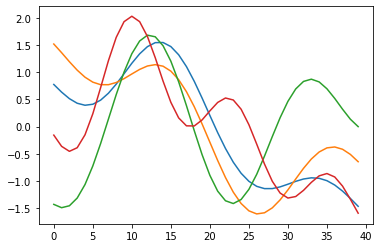

In [ ]:
r = dummy_data_generator(30,10)
plt.plot(r[0][0,:])
plt.plot(r[1][0,:])
plt.plot(r[2][0,:])
plt.plot(r[3][0,:])

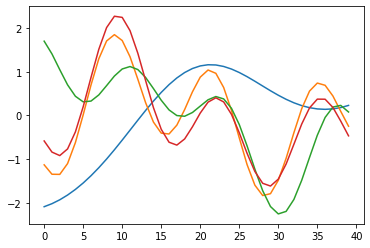

In [ ]:
r = dummy_data_generator(30,10,norm=True)
plt.plot(r[0][0,:])
plt.plot(r[1][0,:])
plt.plot(r[2][0,:])
plt.plot(r[3][0,:])

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.metrics.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted index.ipynb.
